In [ ]:
import acoular as ac
from IPython.core.display import HTML
from IPython.core.magic import register_line_magic
from IPython.display import Audio

def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">
<img src="img/dtu_Blue_RGB.png" alt="DTU Logo" style="width:70px; position:absolute; top:0px; right:440px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">Modelling flow environments for the  correction of aeroacoustic microphone array measurements</h1>
<h3 style="margin-top: 50px; margin-bottom: 50px; color: #434343;">Oliver Lylloff (OLLYL@DTU.DK), DTU, Department of Wind and Energy Systems,<br>
Mikolaj Czuchaj, Gert Herold, Adam Kujawski, Art Pelling and Ennes Sarradj, TU Berlin, Fachgebiet Technische Akustik.</h3>

<h5 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Jupyter Notebook available at <a href="https://github.com/acoular/workshop_DAS-DAGA-2025">https://github.com/acoular/workshop_DAS-DAGA-2025</a></h5>

## Case-study: Aeroacoustic wind tunnel tests
<div style="display: flex; align-items: center;">
    <div style="flex: 60%; padding-right: 10px;">
        <ul>
            <li>Application of microphone array methods in an anechoic wind tunnel</li>
            <li>Modelling of flow environments</li>
            <li>Benchmark case with data from wind tunnel</li>
        </ul>
    </div>
    <div style="flex: 40%; text-align: right;">
        <img src="img/plct.jpeg" width="500">
    </div>
</div>


## Disclaimer
<div style="display: flex; align-items: center;">
    <div style="flex: 50%; padding-right: 10px;">
        <li> I am a fan and user of Acoular, but I am also the developer of another software library called <a href="https://github.com/1oly/AeroAcoustics.jl">AeroAcoustics.jl</a></li>
        <li> I believe that the microphone array community can benefit from having multiple open-source libraries </li>
        <li> I also believe that we can mutually improve code quality and features by benchmarking and ensuring interoperability. </li>
    </div>
    <div style="flex: 50%; text-align: right;">
        <img src="img/AeroAcousticsjl_github.png" width="500">
    </div>
</div>


## Poul la Cour Tunnel at DTU
<div style="display: flex; align-items: center;">
    <div style="flex: 80%; padding-right: 10px;">
        <ul>
            <li>Dedicated to wind energy research, i.e. testing airfoil models</li>
            <li>Anechoic room around test section with Kevlar side walls</li>
            <li>Microphone array situated outside of the flow</li>
        </ul>
    </div>
    <div style="flex: 20%; text-align: right;">
        <img src="img/test_section_overview.png" width="500">
    </div>
</div>

| Attribute                   | Dimension  | Description|
|-----------------------------|------------|------------------------------------------------|
| Anechoic room  | 13 x 11 x 11.5 (L x W x H) [m]  | Anechoic above 100Hz  |
| Test section   | 6 x 3 x 2  (L x W x H) [m] | Interchangeable side walls|
| Test item size | 2m span and up to 1.25m chord | Typically 2D airfoil models |
| Flow speed | 110m/s (hard walls) and 90m/s (kevlar walls) | Powered by a 2.4MW fan |
| Max Reynolds numbers* tested | 9mio (hard walls) and 6mio (kevlar walls) | *chord-based |

## Flow environments
Consider an acoustic points source.
<div style="display: flex; align-items: center;">
        <img src="img/wave_animation.gif" width="250">
        <img src="img/wave_animation_flow.gif" width="250">
        <img src="img/wave_animation_shear.gif" width="250">
</div>
Convection and shear-layer refraction must be accounted for to localize source with microphone array.

## Benchmark test case
*Airfoil in kevlar-walled windtunnel:*

https://github.com/MicrophoneArrayBenchmarking/airfoil-in-kevlar-walled-windtunnel


Benchmark study of two open source libraries for microphone array processing:

*[State of open-source software for microphone array processing](https://www.bebec.eu/fileadmin/bebec/downloads/bebec-2024/papers/BeBeC-2024-S11.pdf)*   
Lylloff, O., Herold, G., Kujawski, A., and Sarradj, E.   
Paper presented at 10th Berlin Beamforming Conference 2024, Berlin, Germany.


Based on this dataset, we demonstrate how to use Acoular:

In [ ]:
import acoular as ac
import numpy as np
import matplotlib.pyplot as plt
from acoular.aiaa import MicAIAABenchmark, CsmAIAABenchmark

Get the data from [data.dtu.dk](https://doi.org/10.11583/DTU.c.7222614) and save in this directory.
The data format follows the AIAA HDF5 definition. Utilities for loading this data format is included in Acoular:

In [ ]:
import requests
url = 'https://data.dtu.dk/ndownloader/files/46174503'
csm_file = 'DTU_PLCT_NACA63018_trip_5PS_5SS_U0_50_AoA_0_octave12_CsmEss.h5'
response = requests.get(url)
if response.status_code == 200:
    with open(csm_file, "wb") as file:
        file.write(response.content)

In [ ]:
mg = MicAIAABenchmark(file=csm_file) # microphone geometry
csm = CsmAIAABenchmark(file=csm_file) # cross-spectral matrix

Define a computational grid

In [5]:
rg = ac.RectGrid(x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0, z=2.3,increment=0.05)
rg.x_min = -2.0
rg.x_max = 2.0 

First, let's plot acoustic images at selected frequencies without accounting for a shear layer

In [14]:
env = ac.Environment(c=338.21164) # from speedOfSoundMPersS in csm_file
st = ac.SteeringVector(env=env, mics=mg, grid=rg, steer_type='true level')
bb = ac.BeamformerBase(freq_data=csm, steer=st, r_diag=True)

Define frequencies for plot

In [15]:
frequencies = [500, 1000, 2000, 4000]

[('DTU_PLCT_NACA63018_trip_5PS_5SS_U0_50_AoA_0_octave12_CsmEss_cache.h5', 3)]


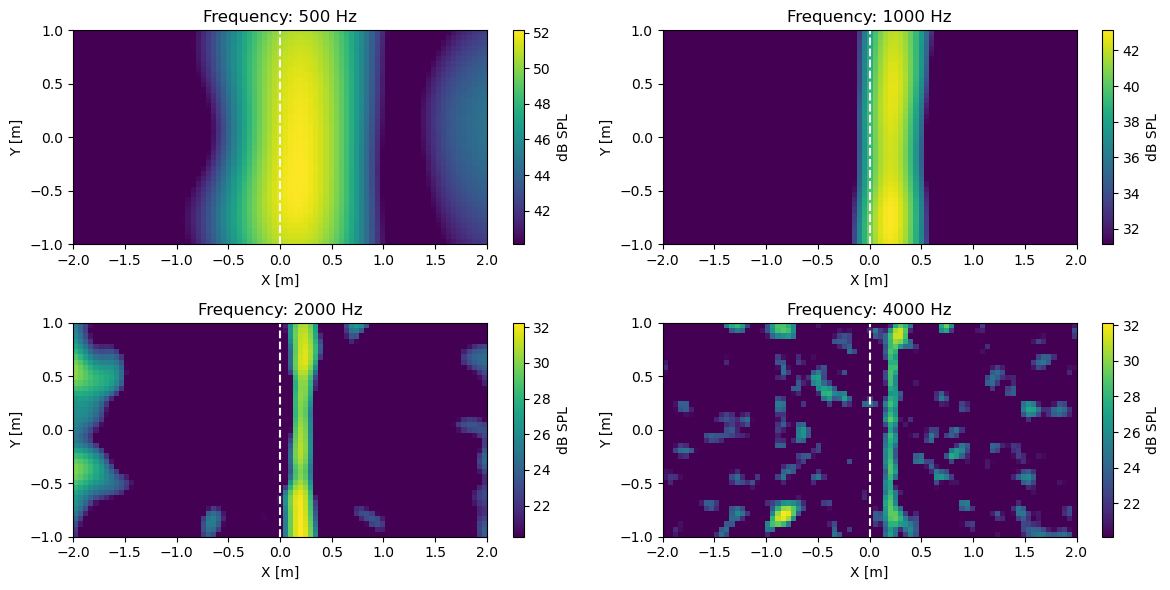

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 2x2 grid for 4 frequencies
for i, f in enumerate(frequencies):
    # Find the closest frequency index in the frequency data
    ind = np.argmin((csm.fftfreq() - f) ** 2)
    
    # Compute the beamforming map for the selected frequency
    beam_map = 10 * np.log10(bb.synthetic(csm.fftfreq()[ind], 0)+1e-12) + 94
    hmax = np.nanmax(beam_map)
    ax = axes[i // 2, i % 2]
    
    # Plot the beamforming map
    im = ax.imshow(
        beam_map.T,
        origin="lower",
        extent=(-2,2,-1,1), vmin=hmax-12,
        aspect="auto"
    )
    ax.axvline(x=0, color='white', linestyle='--', linewidth=1.5) # mark true source position
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("dB SPL")
    
    ax.set_title(f"Frequency: {f} Hz")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

plt.tight_layout()

#### Shear layer correction
In Acoular, a shear-layer correction can be modelled with the SlotJet environment:

In [9]:
jet = ac.SlotJet( v0=50.0, flow=(1,0,0), origin=(-2.01,0,2.3), B=2*(2.3-0.8)) 
env1 = ac.GeneralFlowEnvironment(ff=jet, N=400, c=338.21164, Om=1.2*np.pi)

Plot velocity field using quiver

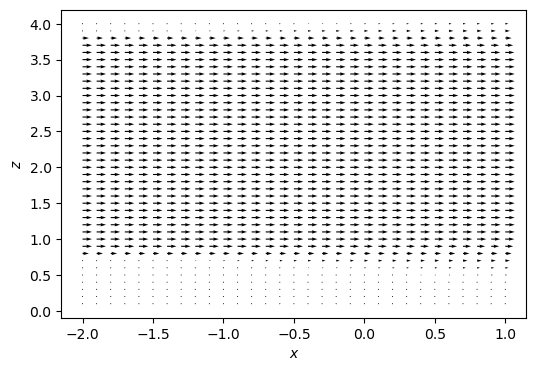

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
x,z = np.mgrid[-2.0:1.0:31j,0.1:4:40j]
v = []
for xi,zi in zip(x.flatten(),z.flatten()):
    v.append(jet.v((xi,0,zi))[0])
v = np.array(v)
vx = v[:,0].reshape(x.shape)
vz = v[:,2].reshape(x.shape)
ax.quiver(x,z,vx,vz)
ax.set_xlabel('$x$')
ax.set_ylabel('$z$');

Finally, apply the flow environment and plot acoustic images.

In [17]:
st = ac.SteeringVector(env=env1, mics=mg, grid=rg, steer_type='true level')
bb = ac.BeamformerBase(freq_data=csm, steer=st, r_diag=True)

[('DTU_PLCT_NACA63018_trip_5PS_5SS_U0_50_AoA_0_octave12_CsmEss_cache.h5', 4)]


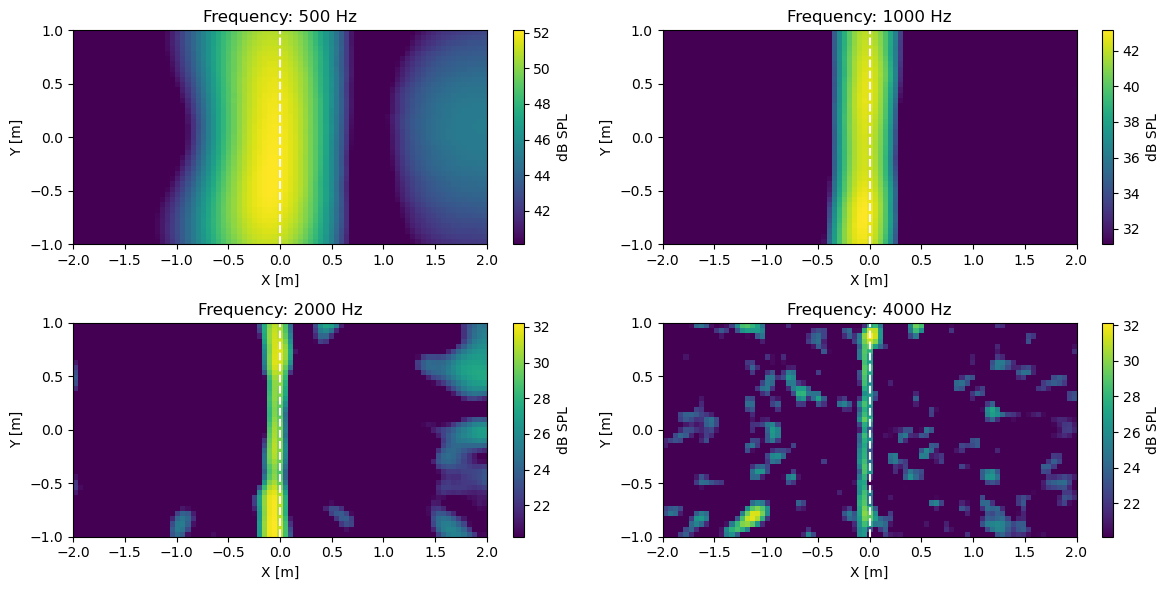

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 2x2 grid for 4 frequencies
for i, f in enumerate(frequencies):
    # Find the closest frequency index in the frequency data
    ind = np.argmin((csm.fftfreq() - f) ** 2)
    
    # Compute the beamforming map for the selected frequency
    beam_map = 10 * np.log10(bb.synthetic(csm.fftfreq()[ind], 0)+1e-12) + 94
    hmax = np.nanmax(beam_map)
    ax = axes[i // 2, i % 2]
    
    # Plot the beamforming map
    im = ax.imshow(
        beam_map.T,
        origin="lower",
        extent=(-2,2,-1,1), vmin=hmax-12,
        aspect="auto"
    )
    ax.axvline(x=0, color='white', linestyle='--', linewidth=1.5) # mark true source position
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("dB SPL")
    
    ax.set_title(f"Frequency: {f} Hz")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

plt.tight_layout()

## Advanced modelling approaches - current research topic.
<div style="display: flex; align-items: center;">
    <div style="flex: 50%; padding-right: 10px;">
        <ul>
        <li> Aerodynamic loading on the Kevlar wall influences the transmission of sound through it. </li>
        <li> An analytical model to correct for the effect of aerodynamic loading has been developed.</li>
        <li> The analytical model was able to predict the effects of transmission loss through the Kevlar walls within an uncertainty of ± 1 dB.</li>
        </ul>
    </div>
    <div style="flex: 50%; text-align: right;">
        <img src="img/AIAA2024_kevlar_wall.gif" width="500">
    </div>
</div>

*Experimental Investigation of the Influence of Aerodynamic Loading on the Transmission Loss Through Kevlar Membranes*   
Fischer, A,, Lylloff, O., Olsen, A. S., Gaunaa, M., and Bak, C. Proceedings of 30th AIAA/CEAS Aeroacoustics Conference (2024).